In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prismg.io import vcf_reader as vcfio
from prismg.utils.grm import standardize_by_af, compute_grm
from prismg.metrics.pli import compute_pli
from prismg.metrics.kri import compute_kri
from prismg.metrics.tli import compute_tli
from prismg.score import r_raw, calibrate_to_prism, choose_targets_from_anchors, fit_weights_anchor
from prismg.bootstrap import bootstrap_analysis, grid_search
from prismg.utils import plotting

In [2]:
RANDOM_SEED   = 123
TRAIN_FRAC    = 0.8

# Parameters for PLI 
N_COMPONENTS  = 10
Q_LOWER       = 0.01

# Parameters for KRI
THETA_REPLAY = 0.125
TAU_REPLAY   = 0.01
IKE_THETAS   = (0.1, 0.125, 0.25)
N_BOOT       = 10

# Parameters for TLI
RARE_MAF = 1e-3
ALPHA_AF = 1e-3
K_MINOR = 0

In [3]:
# ==================== Paths ====================
# Datasets
REAL_VCF = "example_data/1000G_10K_SNP_chr15.vcf.gz"
GAN_VCF  = "example_data/GAN_10K_SNP_chr15.vcf.gz"
RBM_VCF  = "example_data/RBM_10K_SNP_chr15.vcf.gz"
GENOMATOR_H1_VCF = "example_data/GENOMATOR_10K_chr15.vcf.gz"
GENOMATOR_H10_VCF = "example_data/GENOMATOR_10K_H10_chr15.vcf.gz"
GENOMATOR_H50_VCF = "example_data/GENOMATOR_10K_H50_chr15.vcf.gz"

# Calibrators
LEAKY_VCF = "example_data/LEAKY_kindoped_chr15.vcf.gz"
SAFE_VCF = "example_data/SAFE_chr15_binomial_panel.vcf.gz"

# SNP Positions
LEGEND   = "example_data/10K_SNP.legend"

In [4]:
legend_keys = vcfio.load_snp_legend_pos_keys(LEGEND)
real_samples, real_meta, real_G = vcfio.load_vcf(REAL_VCF, keep_pos=legend_keys)
gan_samples,  gan_meta,  gan_G  = vcfio.load_vcf(GAN_VCF,  keep_pos=legend_keys)
rbm_samples,  rbm_meta,  rbm_G  = vcfio.load_vcf(RBM_VCF,  keep_pos=legend_keys)
genom_h1_samples,  genom_h1_meta,  genom_h1_G  = vcfio.load_vcf(GENOMATOR_H1_VCF,  keep_pos=legend_keys)
genom_h10_samples,  genom_h10_meta,  genom_h10_G  = vcfio.load_vcf(GENOMATOR_H10_VCF,  keep_pos=legend_keys)
genom_h50_samples,  genom_h50_meta,  genom_h50_G  = vcfio.load_vcf(GENOMATOR_H50_VCF,  keep_pos=legend_keys)

leaky_samples,  leaky_meta,  leaky_G  = vcfio.load_vcf(LEAKY_VCF,  keep_pos=legend_keys)
safe_samples,  safe_meta,  safe_G  = vcfio.load_vcf(SAFE_VCF,  keep_pos=legend_keys)

In [5]:
# ==================== Train/Holdout split ====================
rng = np.random.RandomState(RANDOM_SEED)
idx = np.arange(len(real_samples))
rng.shuffle(idx)
cut = int(len(idx) * TRAIN_FRAC)
tr_idx, ho_idx = idx[:cut], idx[cut:]

R_tr_samples = [real_samples[i] for i in tr_idx]
R_ho_samples = [real_samples[i] for i in ho_idx]
G_tr, G_ho   = real_G[tr_idx, :], real_G[ho_idx, :]

print(f"(TRAIN={len(R_tr_samples)}, HOLDOUT={len(R_ho_samples)})")

(TRAIN=2003, HOLDOUT=501)


In [9]:
# ==================== Proximity leakage index ====================
res_gan = compute_pli(G_tr, G_ho, 
                      gan_G, n_components = N_COMPONENTS,
                      random_state=RANDOM_SEED,
                      q = Q_LOWER)

res_rbm = compute_pli(G_tr, G_ho, 
                      rbm_G, n_components = N_COMPONENTS,
                      random_state=RANDOM_SEED,
                      q = Q_LOWER)

res_genom_h1 = compute_pli(G_tr, G_ho, 
                      genom_h1_G, n_components = N_COMPONENTS,
                      random_state=RANDOM_SEED,
                      q = Q_LOWER)

res_genom_h10 = compute_pli(G_tr, G_ho, 
                      genom_h10_G, n_components = N_COMPONENTS,
                      random_state=RANDOM_SEED,
                      q = Q_LOWER)

res_genom_h50 = compute_pli(G_tr, G_ho, 
                      genom_h50_G, n_components = N_COMPONENTS,
                      random_state=RANDOM_SEED,
                      q = Q_LOWER)

res_leaky = compute_pli(G_tr, G_ho, 
                      leaky_G, n_components = N_COMPONENTS,
                      random_state=RANDOM_SEED,
                      q = Q_LOWER)

res_safe = compute_pli(G_tr, G_ho, 
                      safe_G, n_components = N_COMPONENTS,
                      random_state=RANDOM_SEED,
                      q = Q_LOWER)
df = pd.DataFrame([
    {"dataset":"GAN", "rho_q":res_gan["rho_q"], "r_p":res_gan["r_p"],
     "A":res_gan["A"], "r_A":res_gan["r_A"], "PLI":res_gan["PLI"]},
    {"dataset":"RBM", "rho_q":res_rbm["rho_q"], "r_p":res_rbm["r_p"],
     "A":res_rbm["A"], "r_A":res_rbm["r_A"], "PLI":res_rbm["PLI"]},
    {"dataset":"Genomator_H1", "rho_q":res_genom_h1["rho_q"], "r_p":res_genom_h1["r_p"],
     "A":res_genom_h1["A"], "r_A":res_genom_h1["r_A"], "PLI":res_genom_h1["PLI"]},
    {"dataset":"Genomator_H10", "rho_q":res_genom_h10["rho_q"], "r_p":res_genom_h10["r_p"],
     "A":res_genom_h10["A"], "r_A":res_genom_h10["r_A"], "PLI":res_genom_h10["PLI"]},
    {"dataset":"Genomator_H50", "rho_q":res_genom_h50["rho_q"], "r_p":res_genom_h50["r_p"],
     "A":res_genom_h50["A"], "r_A":res_genom_h50["r_A"], "PLI":res_genom_h50["PLI"]},
    {"dataset":"Leaky Copycat", "rho_q":res_leaky["rho_q"], "r_p":res_leaky["r_p"],
     "A":res_leaky["A"], "r_A":res_leaky["r_A"], "PLI":res_leaky["PLI"]},
    {"dataset":"Safe binomial", "rho_q":res_safe["rho_q"], "r_p":res_safe["r_p"],
     "A":res_safe["A"], "r_A":res_safe["r_A"], "PLI":res_safe["PLI"]},
])
df = df.round(4)
display(df)

,dataset,rho_q,r_p,A,r_A,PLI
0,GAN,1.0529,0.0000,0.3493,0.3014,0.3014
1,RBM,1.0986,0.0000,0.3273,0.3453,0.3453
2,Genomator_H1,0.1913,0.8087,0.0858,0.8283,0.8283
3,Genomator_H10,0.4122,0.5878,0.0958,0.8084,0.8084
4,Genomator_H50,0.7379,0.2621,0.1337,0.7325,0.7325
5,Leaky Copycat,0.0000,1.0000,0.0739,0.8523,1.0000
6,Safe binomial,3.3639,0.0000,0.9940,0.0000,0.0000


In [10]:
# ==================== Kinship replay index ====================
var_chr = [chrom for chrom, pos, ref, alt in real_meta]

res_gan = compute_kri(G_tr, G_ho, gan_G, var_chr,
                      theta=THETA_REPLAY, tau=TAU_REPLAY,
                      ike_thetas=IKE_THETAS, n_boot=N_BOOT,
                      seed=RANDOM_SEED)
    
res_rbm = compute_kri(G_tr, G_ho, rbm_G, var_chr,
                      theta=THETA_REPLAY, tau=TAU_REPLAY,
                      ike_thetas=IKE_THETAS, n_boot=N_BOOT,
                      seed=RANDOM_SEED)

res_genom_h1 = compute_kri(G_tr, G_ho, genom_h1_G, var_chr,
                      theta=THETA_REPLAY, tau=TAU_REPLAY,
                      ike_thetas=IKE_THETAS, n_boot=N_BOOT,
                      seed=RANDOM_SEED)

res_genom_h10 = compute_kri(G_tr, G_ho, genom_h10_G, var_chr,
                      theta=THETA_REPLAY, tau=TAU_REPLAY,
                      ike_thetas=IKE_THETAS, n_boot=N_BOOT,
                      seed=RANDOM_SEED)

res_genom_h50 = compute_kri(G_tr, G_ho, genom_h50_G, var_chr,
                      theta=THETA_REPLAY, tau=TAU_REPLAY,
                      ike_thetas=IKE_THETAS, n_boot=N_BOOT,
                      seed=RANDOM_SEED)

res_leaky = compute_kri(G_tr, G_ho, leaky_G, var_chr,
                      theta=THETA_REPLAY, tau=TAU_REPLAY,
                      ike_thetas=IKE_THETAS, n_boot=N_BOOT,
                      seed=RANDOM_SEED)

res_safe = compute_kri(G_tr, G_ho, safe_G, var_chr,
                      theta=THETA_REPLAY, tau=TAU_REPLAY,
                      ike_thetas=IKE_THETAS, n_boot=N_BOOT,
                      seed=RANDOM_SEED)

df = pd.DataFrame([
    {"dataset":"GAN", **{k:v for k,v in res_gan.items() if k!="dbg"}},
    {"dataset":"RBM", **{k:v for k,v in res_rbm.items() if k!="dbg"}},
    {"dataset":"Genomator_H1", **{k:v for k,v in res_genom_h1.items() if k!="dbg"}},
    {"dataset":"Genomator_H10", **{k:v for k,v in res_genom_h10.items() if k!="dbg"}},
    {"dataset":"Genomator_H50", **{k:v for k,v in res_genom_h50.items() if k!="dbg"}},
    {"dataset":"Leaky Copycat", **{k:v for k,v in res_leaky.items() if k!="dbg"}},
    {"dataset":"Safe binomial", **{k:v for k,v in res_safe.items() if k!="dbg"}},
])
df = df.round(4)
display(df)

,dataset,r_replay,r_IKE,r_HAP,r_SPEC,KRI,debug
0,GAN,0.0000,0.2662,0.0000,0.4354,0.4354,"{'replay': {'obs': 0.9998611882287618, 'base':..."
1,RBM,0.0000,0.0000,0.0178,0.0000,0.0178,"{'replay': {'obs': 0.9976401998889506, 'base':..."
2,Genomator_H1,0.0000,0.0000,0.0000,0.7504,0.7504,"{'replay': {'obs': 0.9980566352026652, 'base':..."
3,Genomator_H10,0.0262,0.0198,0.0040,0.7889,0.7889,"{'replay': {'obs': 0.9981954469739034, 'base':..."
4,Genomator_H50,0.0000,0.0567,0.0288,0.8134,0.8134,"{'replay': {'obs': 0.997917823431427, 'base': ..."
5,Leaky Copycat,0.0000,0.0420,0.0000,0.2060,0.2060,"{'replay': {'obs': 0.9998611882287618, 'base':..."
6,Safe binomial,0.0000,0.0000,0.0000,0.0000,0.0000,"{'replay': {'obs': 0.5694058856191005, 'base':..."


In [12]:
# ==================== Trait-linked leakage index ====================
res_gan = compute_tli(G_tr, G_ho, gan_G, 
                      var_chr, maf_thresh=RARE_MAF, alpha=ALPHA_AF, k_minor=K_MINOR,
                      min_train_calls_frac=TRAIN_FRAC) 

res_rbm = compute_tli(G_tr, G_ho, rbm_G, 
                      var_chr, maf_thresh=RARE_MAF, alpha=ALPHA_AF, k_minor=K_MINOR, 
                      min_train_calls_frac=TRAIN_FRAC)   # same knobs

res_genom_h1 = compute_tli(G_tr, G_ho, genom_h1_G, 
                           var_chr, maf_thresh=RARE_MAF, alpha=ALPHA_AF, k_minor=K_MINOR, 
                           min_train_calls_frac=TRAIN_FRAC)

res_genom_h10 = compute_tli(G_tr, G_ho, genom_h10_G, 
                            var_chr, maf_thresh=RARE_MAF, alpha=ALPHA_AF, k_minor=K_MINOR, 
                            min_train_calls_frac=TRAIN_FRAC) 

res_genom_h50 = compute_tli(G_tr, G_ho, genom_h50_G, 
                            var_chr, maf_thresh=RARE_MAF, alpha=ALPHA_AF, k_minor=K_MINOR, 
                            min_train_calls_frac=TRAIN_FRAC)   # same knobs


res_leaky = compute_tli(G_tr, G_ho, leaky_G, 
                        var_chr, maf_thresh=RARE_MAF, alpha=ALPHA_AF, k_minor=K_MINOR, 
                        min_train_calls_frac=TRAIN_FRAC)

res_safe = compute_tli(G_tr, G_ho, safe_G, 
                       var_chr, maf_thresh=RARE_MAF, alpha=ALPHA_AF, k_minor=K_MINOR, 
                       min_train_calls_frac=TRAIN_FRAC)   # same knobs

df = pd.DataFrame([
    {"dataset":"GAN", **{k:v for k,v in res_gan.items() if k!="dbg"}},
    {"dataset":"RBM", **{k:v for k,v in res_rbm.items() if k!="dbg"}},
    {"dataset":"Genomator_H1", **{k:v for k,v in res_genom_h1.items() if k!="dbg"}},
    {"dataset":"Genomator_H10", **{k:v for k,v in res_genom_h10.items() if k!="dbg"}},
    {"dataset":"Genomator_H50", **{k:v for k,v in res_genom_h50.items() if k!="dbg"}},
    {"dataset":"Leaky Copycat", **{k:v for k,v in res_leaky.items() if k!="dbg"}},
    {"dataset":"Safe binomial", **{k:v for k,v in res_safe.items() if k!="dbg"}},
])
df = df.round(4)
display(df)

,dataset,MIA_AUC,r_mia,U,U0,r_uniq,TLI_final
0,GAN,0.4831,0.0000,0.6639,0.5387,0.2713,0.2713
1,RBM,0.5002,0.0005,0.9052,0.5387,0.7944,0.7944
2,Genomator_H1,0.5195,0.0390,0.0084,0.5381,0.0000,0.0390
3,Genomator_H10,0.5119,0.0238,0.0049,0.5381,0.0000,0.0238
4,Genomator_H50,0.5175,0.0349,0.0031,0.5381,0.0000,0.0349
5,Leaky Copycat,0.5000,0.0000,1.0000,0.5381,1.0000,1.0000
6,Safe binomial,0.5061,0.0121,0.5289,0.5381,0.0000,0.0121


In [13]:
EXAMPLE_DATA = [
    {"name": "GAN", "pli": 0.301, "kri": 0.435, "tli": 0.271, "role": "candidate"},
    {"name": "RBM", "pli": 0.345, "kri": 0.018, "tli": 0.794, "role": "candidate"},
    {"name": "GENOMATOR_H1", "pli": 0.828, "kri": 0.750, "tli": 0.0390, "role": "candidate"},
    {"name": "GENOMATOR_H10", "pli": 0.808, "kri":0.7889, "tli": 0.024, "role": "candidate"},
    {"name": "GENOMATOR_H50", "pli": 0.733, "kri": 0.813, "tli": 0.035, "role": "candidate"},

    # anchors — you can list multiple safe/leaky runs; we take median
    {"name": "Safe binomial",   "pli": 0.0000, "kri": 0.108, "tli": 0.012, "role": "safe anchor"},
    {"name": "Leaky kindoped",  "pli": 1.0000, "kri": 0.206, "tli": 1.0000,   "role": "leaky anchor"},
]
df = pd.DataFrame(EXAMPLE_DATA)

In [14]:
r_safe = [0.0, 0.108, 0.012]
r_leak = [1, 0.206, 1]

eps, lam = choose_targets_from_anchors([r_safe], [r_leak])
w_star = fit_weights_anchor(r_safe, r_leak, eps=0.02, lam=0.75, gamma=1e-3, step=0.01)
print(w_star)

[0.22 0.11 0.67]


In [15]:
# Compute R_raw for each row
df["R_raw"] = df.apply(lambda r: r_raw([r.pli, r.kri, r.tli], w_star), axis=1)

alpha = df.loc[df["name"] == "Safe binomial", "R_raw"].iloc[0]
beta  = df.loc[df["name"] == "Leaky kindoped", "R_raw"].iloc[0]

In [16]:
df["PRISM_G"] = df.apply(
    lambda r: calibrate_to_prism(r.R_raw, alpha, beta),
    axis=1
)

# Pretty print
print(f"alpha (safe)  = {alpha:.5f}")
print(f"beta  (leaky) = {beta:.5f}\n")

display(df)

alpha (safe)  = 0.01982
beta  (leaky) = 0.74843



,name,pli,kri,tli,role,R_raw,PRISM_G
0,GAN,0.301,0.4350,0.271,candidate,0.272335,34.656558
1,RBM,0.345,0.0180,0.794,candidate,0.568359,75.285260
2,GENOMATOR_H1,0.828,0.7500,0.039,candidate,0.269239,34.231626
3,GENOMATOR_H10,0.808,0.7889,0.024,candidate,0.261187,33.126575
4,GENOMATOR_H50,0.733,0.8130,0.035,candidate,0.254178,32.164548
5,Safe binomial,0.000,0.1080,0.012,safe anchor,0.019824,0.000000
6,Leaky kindoped,1.000,0.2060,1.000,leaky anchor,0.748433,100.000000


(<Figure size 900x500 with 2 Axes>,
 <Axes: title={'center': 'PRISM-G (0 = safer, 100 = riskier)'}, ylabel='PRISM-G (0 = safer, 100 = riskier)'>)

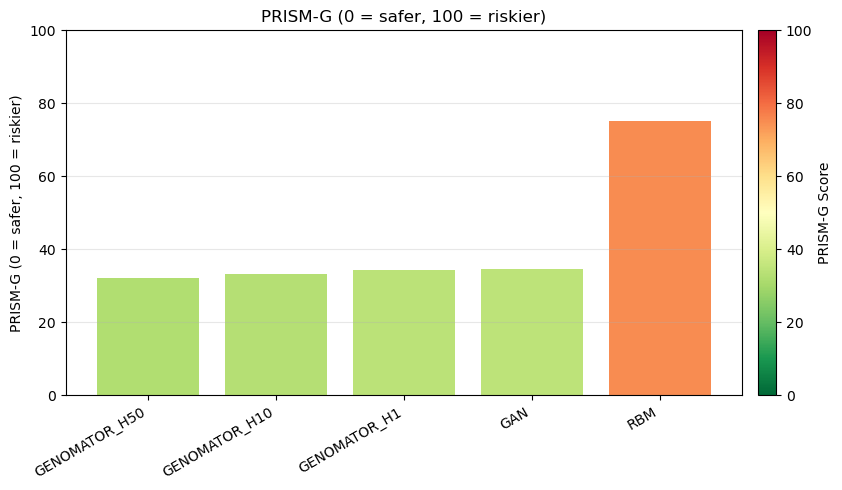

In [17]:
from prismg.utils import plotting
plotting.plot_prismg_summary(df)

In [19]:
eps = 0.02
lam = 0.75
gamma = 0.001
w0 = [0,0,0]

weights_info, tblR, tblG, tblP, ranks, kend, boot_G = bootstrap_analysis(df, B=10, sigma=0.01, eps=eps, lam=lam, gamma=gamma, w0=w0, 
                                                                         refit_weights=True, step=0.01, random_state=RANDOM_SEED)

if isinstance(weights_info, dict):
    print("Weights (refit each draw): mean ± sd  [n={}]:".format(weights_info["n"]))
    print(np.round(weights_info["mean"], 4), "±", np.round(weights_info["sd"], 4))
else:
    print("Baseline weights (fixed):", np.round(weights_info, 4))

print("\nBootstrap PRISM-G (means ± sd):")
print(tblG[["name","mean_G","sd_G","ci95_G_lo","ci95_G_hi"]].round(3).to_string(index=False))

print("\nPairwise PRISM-G differences (two-sided p-values):")
print(tblP[["A_minus_B","mean_diff","ci95_diff_lo","ci95_diff_hi", "p_two_sided","p_fmt"]].to_string(index=False))
print(kend)

Weights (refit each draw): mean ± sd  [n=10]:
[0.409 0.071 0.52 ] ± [0.2001 0.0475 0.1731]

Bootstrap PRISM-G (means ± sd):
         name  mean_G   sd_G  ci95_G_lo  ci95_G_hi
          RBM  66.553 10.432     51.119     76.700
 GENOMATOR_H1  50.976 18.282     32.017     75.899
GENOMATOR_H10  49.477 17.953     31.212     74.164
GENOMATOR_H50  46.223 15.647     30.622     68.196
          GAN  34.766  0.786     33.711     35.795

Pairwise PRISM-G differences (two-sided p-values):
                    A_minus_B  mean_diff  ci95_diff_lo  ci95_diff_hi  p_two_sided     p_fmt
                    GAN - RBM -31.787288    -41.809724    -15.351748          0.0  <1x10^-1
 GENOMATOR_H1 - GENOMATOR_H10   1.498693      0.805169      1.902099          0.0  <1x10^-1
GENOMATOR_H10 - GENOMATOR_H50   3.254287      0.219100      5.967898          0.0  <1x10^-1
 GENOMATOR_H1 - GENOMATOR_H50   4.752979      1.024269      7.702753          0.0  <1x10^-1
          GAN - GENOMATOR_H50 -11.457206    -32.429513    

(<Figure size 900x500 with 2 Axes>,
 <Axes: title={'center': 'Bootstrap PRISM-G'}, ylabel='PRISM-G (0 = safer, 100 = riskier)'>)

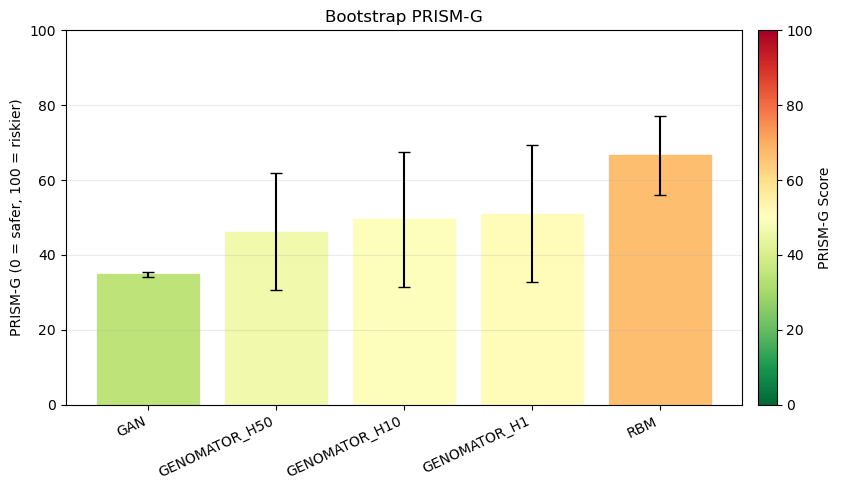

In [20]:
from prismg.utils import plotting
plotting.plot_boot_barplot(boot_G, tblG)

In [21]:
# Define the grids you want to scan
eps_grid = [0.02, 0.04, 0.06, 0.08, 0.10]
lam_grid = [0.75, 0.80, 0.85, 0.90]
gamma_grid = [1e-4, 1e-3, 1e-2]

# Run the grid search (reusing your EXAMPLE_DATA DataFrame `df`)
res = grid_search(df, eps_grid=eps_grid, lam_grid=lam_grid, gamma_grid=gamma_grid, B=10, sigma=0.01, w0=(0,0,0), step=0.01, 
                          refit_weights=True, random_state=RANDOM_SEED)

# See the top settings by mean Kendall τ
print(res.to_string(index=False))

 eps  lam  gamma  mean_tau   sd_tau  tau_ci_lo  tau_ci_hi  p_tau                                               modal_rank  modal_prop  N_boot  w_PLI_mean  w_KRI_mean  w_TLI_mean  w_PLI_sd  w_KRI_sd  w_TLI_sd
0.02 0.75 0.0100      0.74 0.298887      0.400        1.0    0.0 RBM > GENOMATOR_H1 > GENOMATOR_H10 > GENOMATOR_H50 > GAN         0.5      10       0.468       0.053       0.479  0.135302  0.022136  0.128534
0.04 0.80 0.0100      0.70 0.483046     -0.200        1.0    0.2 RBM > GAN > GENOMATOR_H1 > GENOMATOR_H10 > GENOMATOR_H50         0.5      10       0.263       0.104       0.633  0.258631  0.025473  0.252369
0.04 0.90 0.0001      0.68 0.674619     -0.600        1.0    0.0 RBM > GAN > GENOMATOR_H50 > GENOMATOR_H1 > GENOMATOR_H10         0.8      10       0.180       0.098       0.722  0.379473  0.007888  0.375316
0.06 0.90 0.0001      0.68 0.674619     -0.600        1.0    0.0 RBM > GAN > GENOMATOR_H50 > GENOMATOR_H1 > GENOMATOR_H10         0.8      10       0.179       0.099   

In [22]:
eps = 0.02
lam = 0.75
gamma = 0.01
w0 = [0,0,0]

weights_info, tblR, tblG, tblP, ranks, kend, boot_G = bootstrap_analysis(df, B= 10, sigma=0.01, eps=eps, lam=lam, gamma=gamma, w0=w0, 
                                                                         refit_weights=True, step=0.01, random_state=RANDOM_SEED)

if isinstance(weights_info, dict):
    print("Weights (refit each draw): mean ± sd  [n={}]:".format(weights_info["n"]))
    print(np.round(weights_info["mean"], 4), "±", np.round(weights_info["sd"], 4))
else:
    print("Baseline weights (fixed):", np.round(weights_info, 4))

print("\nBootstrap PRISM-G (means ± sd):")
print(tblG[["name","mean_G","sd_G","ci95_G_lo","ci95_G_hi"]].round(3).to_string(index=False))

print("\nPairwise PRISM-G differences (two-sided p-values):")
print(tblP[["A_minus_B","mean_diff","ci95_diff_lo","ci95_diff_hi", "p_two_sided","p_fmt"]].to_string(index=False))
print(kend)

Weights (refit each draw): mean ± sd  [n=10]:
[0.468 0.053 0.479] ± [0.1353 0.0221 0.1285]

Bootstrap PRISM-G (means ± sd):
         name  mean_G   sd_G  ci95_G_lo  ci95_G_hi
          RBM  64.795  7.905     54.047     74.050
 GENOMATOR_H1  56.359 13.475     40.002     73.716
GENOMATOR_H10  54.698 13.317     38.718     72.012
GENOMATOR_H50  50.679 11.761     36.966     66.360
          GAN  35.193  0.792     34.315     36.579

Pairwise PRISM-G differences (two-sided p-values):
                    A_minus_B  mean_diff  ci95_diff_lo  ci95_diff_hi  p_two_sided     p_fmt
                    GAN - RBM -29.602386    -38.492276    -17.468016          0.0  <1x10^-1
           GAN - GENOMATOR_H1 -21.166394    -37.137747     -4.331979          0.0  <1x10^-1
          GAN - GENOMATOR_H10 -19.505781    -35.433080     -3.047783          0.0  <1x10^-1
          GAN - GENOMATOR_H50 -15.485892    -29.780861     -1.312767          0.0  <1x10^-1
 GENOMATOR_H1 - GENOMATOR_H10   1.660613      1.284196    

(<Figure size 900x500 with 2 Axes>,
 <Axes: title={'center': 'Bootstrap PRISM-G'}, ylabel='PRISM-G (0 = safer, 100 = riskier)'>)

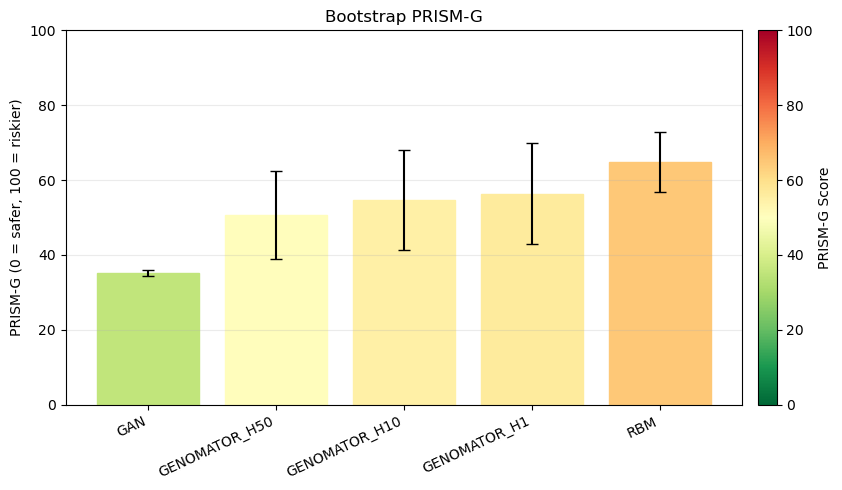

In [23]:
from prismg.utils import plotting
plotting.plot_boot_barplot(boot_G, tblG)